# Milestone 2
## 2.1 Imports and data loading

In [32]:
import findspark
findspark.init()
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import to_timestamp, dayofmonth, month, year, length, udf

import seaborn as sns

In [2]:
DATA_PATH = 'data/'
FILE_NAME_00 = 'amazon_reviews_us_Books_v1_00.tsv.gz'
FILE_NAME_01 = 'amazon_reviews_us_Books_v1_01.tsv.gz'
FILE_NAME_02 = 'amazon_reviews_us_Books_v1_02.tsv.gz'

In [34]:
data_00 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_00)
data_01 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_01)
data_02 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_02)

#data = data_00.union(data_01).union(data_02)
data = data_00

In [35]:
avg_stars = data.groupby('product_id', 'product_title').agg({"star_rating" : "avg", "review_id" : "count", "helpful_votes" : "sum", "total_votes" : "sum"})
avg_stars.persist()

DataFrame[product_id: string, product_title: string, count(review_id): bigint, sum(total_votes): double, avg(star_rating): double, sum(helpful_votes): double]

In [36]:
avg_stars = avg_stars.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('sum(total_votes)', 'total_votes') \
                        .withColumnRenamed('sum(helpful_votes)', 'helpful_votes') \
                        .withColumnRenamed('avg(star_rating)', 'rating') \

In [37]:
avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|      857|     1331.0| 4.141190198366394|       1090.0|
|0062091158|     King (Prophecy)|        2|        1.0|               4.0|          1.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       12|       52.0| 4.666666666666667|         33.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|019513172X|Nothing but Chris...|        1|        0.0|               5.0|          0.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: Fro

In [56]:
avg_stars.count()

2274618

In [38]:
main_avg_stars = avg_stars.where('n_reviews > 10')

In [39]:
main_avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|      857|     1331.0| 4.141190198366394|       1090.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       12|       52.0| 4.666666666666667|         33.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: From Lost t...|     1350|     2734.0| 4.099259259259259|       2203.0|
|1416299025|Outlander 2016 Bo...|       11|       54.0|4.7272727272727275|         50.0|
|1572840994|Gluten-Fr

In [40]:
main_avg_stars.count()

173707

In [41]:
by_product = main_avg_stars.toPandas()

In [42]:
by_product['ratio_helpful'] = by_product['helpful_votes'] / by_product['total_votes']

In [55]:
by_product.sort_values(by='n_reviews')

,product_id,product_title,n_reviews,total_votes,rating,helpful_votes,ratio_helpful
91887,031042366X,"NASB, Skinii Bible, Imitation Leather, Black",11,42.0,4.272727,27.0,0.642857
24404,0446578223,"Single, Saved, and Having Sex",11,1.0,4.636364,0.0,0.000000
69573,0825434831,Bible Explorer's Guide: How to Understand and ...,11,1.0,4.636364,1.0,1.000000
24398,0439376459,Ricky Ricotta's Mighty Robot vs. The Stupid St...,11,1.0,4.636364,0.0,0.000000
152302,0805091319,"Revolutionary Russia, 1891-1991: A History",11,168.0,4.636364,138.0,0.821429
152303,0805094946,The Land of Decoration: A Novel,11,6.0,4.000000,5.0,0.833333
111758,161614680X,London Eye (Toxic City),11,17.0,3.454545,14.0,0.823529
69582,0843174919,Follow Your Heart: Finding Purpose in Your Lif...,11,7.0,4.727273,6.0,0.857143
69590,0870612417,Interior Castle: The Classic Text With a Spiri...,11,21.0,4.818182,11.0,0.523810
69594,0882661779,Braiding Rugs: A Storey Country Wisdom Bulleti...,11,13.0,3.727273,7.0,0.538462


## 2.2 Rating vs vote counts & helpful votes

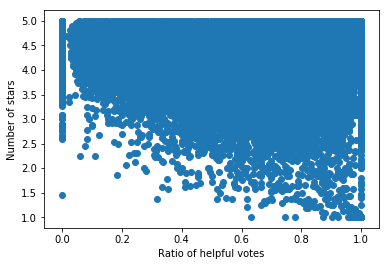

In [44]:
plt.scatter(by_product['ratio_helpful'], by_product['rating'])
plt.xlabel('Ratio of helpful votes')
plt.ylabel('Number of stars')
plt.show()

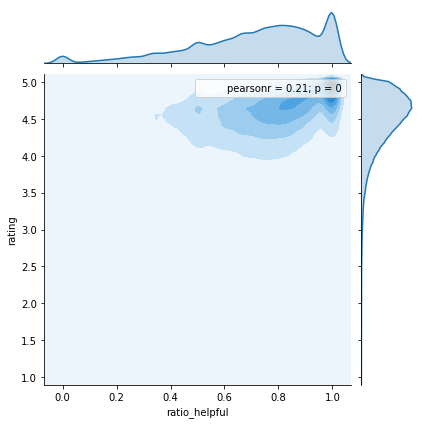

In [45]:
sns.jointplot(x = by_product['ratio_helpful'], y = by_product['rating'], kind='kde')

**Observation**<br>
We can see that the lower the number of helpful votes is, the higher the rating. However, unfortunately we cannot come up with an possible explanation for the ratio of helpful votes to influence the rating, so we cannot reason if the relationship is causal.

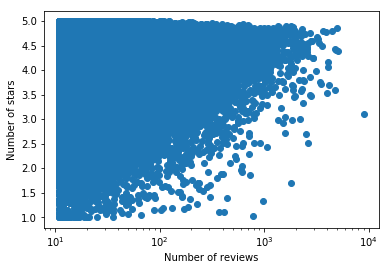

In [16]:
plt.scatter(by_product['n_reviews'], by_product['rating'])
plt.xscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Number of stars')
plt.show()

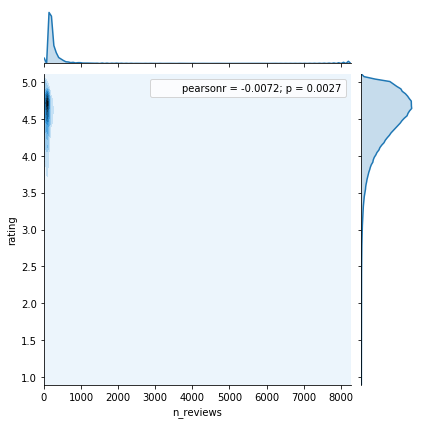

In [46]:
sns.jointplot(x = by_product['n_reviews'], y = by_product['rating'], kind='kde')

**Observation**<br>
We can see that the higher the number of reviews is, the higher the rating. However, the causal relationship is most likely causal in the sense that better products have higher ratings, but better products also have more people that buy them, so more reviews.

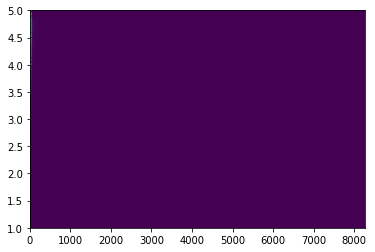

In [52]:
plt.hist2d(by_product['n_reviews'], by_product['rating'], bins=200)
#plt.xlim(0, 100)
plt.show()

## 2.3 Analysis of Time Based Features

In [17]:
by_time = data.select(data['star_rating'],to_timestamp(data['review_date'], 'yyyy-MM-dd').alias('date'), data['review_id'])

In [18]:
by_time_month = by_time.groupby(month('date')).agg({'star_rating' : 'avg', 'review_id' : 'count'}).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('month(date)', 'month')
by_time_month.persist()

DataFrame[month: int, count(review_id): bigint, rating: double]

In [19]:
by_time_month = by_time_month.sort("month")

In [20]:
by_time_month.show()

+-----+----------------+------------------+
|month|count(review_id)|            rating|
+-----+----------------+------------------+
| null|            3121| 4.370060281312793|
|    1|         1935472|4.3539901378061785|
|    2|         1670763| 4.347238956093713|
|    3|         1740418| 4.351264466352336|
|    4|         1575087| 4.342526476315276|
|    5|         1601946|  4.34153523277314|
|    6|         1583909| 4.332101149750396|
|    7|         1752737| 4.342714851115712|
|    8|         1793909| 4.341525684970643|
|    9|         1399667|4.3197289069471525|
|   10|         1439117|  4.33547515594632|
|   11|         1392114| 4.335222546429387|
|   12|         1643069|  4.34829091170243|
+-----+----------------+------------------+



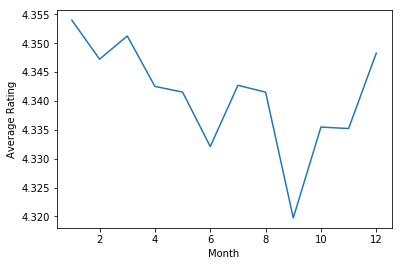

In [21]:
by_month_pd = by_time_month.toPandas()
plt.plot(by_month_pd['month'], by_month_pd['rating'])
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.show()

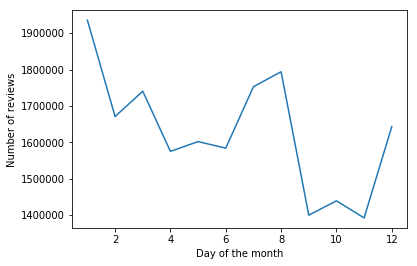

In [22]:
plt.plot(by_month_pd['month'], by_month_pd['count(review_id)'])
plt.xlabel('Day of the month')
plt.ylabel('Number of reviews')
plt.show()

In [23]:
by_time_dayofmonth = by_time.groupby(dayofmonth('date')).agg({'star_rating' : 'avg', 'review_id' : 'count'}).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('dayofmonth(date)', 'dayofmonth')
by_time_dayofmonth.persist()

DataFrame[dayofmonth: int, count(review_id): bigint, rating: double]

In [24]:
by_time_dayofmonth = by_time_dayofmonth.sort("dayofmonth")

In [25]:
by_time_dayofmonth.show()

+----------+----------------+------------------+
|dayofmonth|count(review_id)|            rating|
+----------+----------------+------------------+
|      null|            3121| 4.370060281312793|
|         1|          609228| 4.335020714740622|
|         2|          643125| 4.340126724975705|
|         3|          667346| 4.346716695687095|
|         4|          655368| 4.351817604765567|
|         5|          648720| 4.346238747071156|
|         6|          653951| 4.347406762892021|
|         7|          660410| 4.348955951605821|
|         8|          656937| 4.346165614054316|
|         9|          676756| 4.347256618338071|
|        10|          658070| 4.347750239336241|
|        11|          653627| 4.344953620336981|
|        12|          644180|4.3448057996212235|
|        13|          639382| 4.340602331626477|
|        14|          641162| 4.345653672550775|
|        15|          633264| 4.344229262993001|
|        16|          634742| 4.343489165676763|
|        17|        

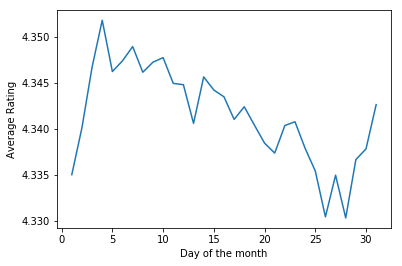

In [26]:
by_dayofmonth_pd = by_time_dayofmonth.toPandas()
plt.plot(by_dayofmonth_pd['dayofmonth'], by_dayofmonth_pd['rating'])
plt.xlabel('Day of the month')
plt.ylabel('Average Rating')
plt.show()

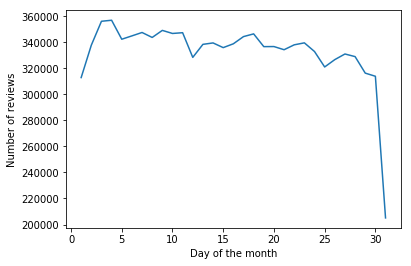

In [25]:
plt.plot(by_dayofmonth_pd['dayofmonth'], by_dayofmonth_pd['count(review_id)'])
plt.xlabel('Day of the month')
plt.ylabel('Number of reviews')
plt.show()

In [27]:
by_time_year = by_time.groupby(year('date')).agg({'star_rating' : 'avg', 'review_id' : 'count'}).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('year(date)', 'year')
by_time_year.persist()

DataFrame[year: int, count(review_id): bigint, rating: double]

In [28]:
by_time_year = by_time_year.sort("year")

In [29]:
by_time_year.show()

+----+----------------+-----------------+
|year|count(review_id)|           rating|
+----+----------------+-----------------+
|null|            3121|4.370060281312793|
|1995|             198|4.611111111111111|
|1996|            4670|4.602355460385439|
|1997|           36610|4.433925157060912|
|1998|          120851|4.304548576346079|
|1999|          244559|4.212570381789262|
|2000|          540476|4.238943079803729|
|2001|          444904|4.199580134141298|
|2002|          426895|4.166542123941484|
|2003|          440007|4.133756962957407|
|2004|          440365|4.116753147956809|
|2005|          516809|4.148062436993164|
|2006|          563599|4.197094033168973|
|2007|          753149|4.258834573238496|
|2008|          819505|4.234401254415776|
|2009|          999366|4.247195722087803|
|2010|         1100489|4.246976571324202|
|2011|         1278058|4.251192825364733|
|2012|         1613698|4.316948400506167|
|2013|         2904577|4.412825344275603|
+----+----------------+-----------

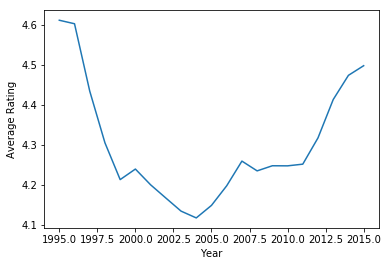

In [30]:
by_year_pd = by_time_year.toPandas()
plt.plot(by_year_pd['year'], by_year_pd['rating'])
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

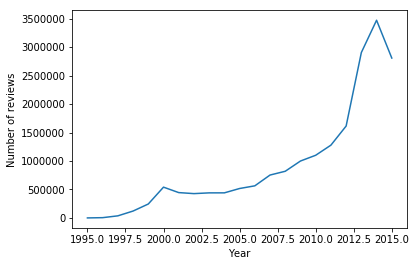

In [31]:
plt.plot(by_year_pd['year'], by_year_pd['count(review_id)'])
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.show()

In [ ]:
div_by_10 = udf(lambda x : 0 if x is None else 10*int(x / 10))
div_by_100 = udf(lambda x : 0 if x is None else 100*int(x / 100))
by_review_length = data.select(data['star_rating'], \
                               div_by_10(length(data['review_headline'])).alias('title_length'), \
                               div_by_100(length(data['review_body'])).alias('body_length'), \
                                      data['review_id'])
by_review_length.persist()

In [32]:
by_review_length.show()

+-----------+------------+-----------+--------------+
|star_rating|title_length|body_length|     review_id|
+-----------+------------+-----------+--------------+
|          5|          10|         30| RJOVP071AVAJO|
|          5|          60|        360|R1ORGBETCDW3AI|
|          5|          10|         50| R7TNRFQAOUTX5|
|          5|          10|         10|R2GANXKDIFZ6OI|
|          5|          10|         80|R2NYB6C3R8LVN6|
|          2|          30|       1500|R13U5PBJI1H94K|
|          5|          50|        740|R1H8UVH990F8VE|
|          5|          10|         10|R2MC0N30WZMRQ5|
|          5|          10|         20| R2NO2HXK16Y4J|
|          5|          10|         30|R245YIAVJK82ZL|
|          5|          10|         10| RFBMLBWQOZ1UM|
|          5|          30|        130| RHE1FEWV3KTQH|
|          5|          10|         20|R2BB9U7PHO7ETO|
|          4|          10|         20|R28XJJP754GYXO|
|          3|          70|        270|R2G519UREHRO8M|
|          5|          10|  

In [33]:

by_title_length = by_review_length.groupby('title_length').agg({'star_rating':'avg', 'review_id':'count'}).\
                    withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_title_length.persist()

DataFrame[title_length: string, count: bigint, rating: double]

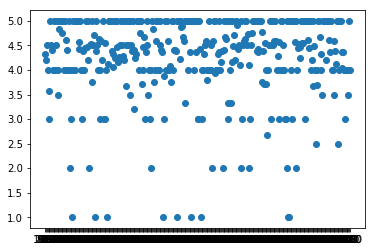

In [34]:
by_title_length_pd = by_title_length.toPandas()
by_title_length_pd
plt.scatter(by_title_length_pd['title_length'], by_title_length_pd['rating'])

In [35]:
by_body_length = by_review_length.groupby('body_length').agg({'star_rating':'avg', 'review_id':'count'}) \
                    .withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_body_length.persist()

DataFrame[body_length: string, count: bigint, rating: double]

In [ ]:
by_body_length.count()

In [ ]:
by_body_length_pd = by_body_length.toPandas()
by_body_length_pd
plt.plot(by_body_length_pd['body_length'], by_body_length_pd['count'])

2